# Importing the Data

In [1]:
# retrieving data
import requests as req

filename="training_data.pkl"
url="https://www.ams.jhu.edu/~dan/FinalAssignmentSpring2024/Train_127a.pkl"

res=req.get(url)
print(res)
with open(filename, 'wb') as fout:
    for chunk in res.iter_content(chunk_size=1024):
        if chunk:
            fout.write(chunk)

/Users/antonshtarkman/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<Response [200]>


In [2]:
filename_test="test_data.pkl"
url2="https://www.ams.jhu.edu/~dan/FinalAssignmentSpring2024/TestPredictors_127a.pkl"

res=req.get(url2)
print(res)
with open(filename_test, 'wb') as fout:
    for chunk in res.iter_content(chunk_size=1024):
        if chunk:
            fout.write(chunk)

<Response [200]>


In [3]:
import pandas as pd
filename="training_data.pkl"
filename_test = "test_data.pkl"
train_df=pd.read_pickle(filename)
test_df=pd.read_pickle(filename_test)

In [9]:
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.1 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 103.3 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 111.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# Functions used to test and fit for regression

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_model(Y_pred, Y_test):
    plt.scatter(Y_pred, Y_test, s=2)
    plt.title('Scatter plot')
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.scatter(Y_pred, Y_test,s=2)
    
    a, b = np.polyfit(Y_pred, Y_test, 1)

    start_Y = min(Y_pred)
    end_Y = max(Y_pred)

    plt.plot(start_Y, end_Y * a + b)
    
    plt.show()


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def regression_test(model, data, needs_training = True, field = "length"):
    X = data.copy()
    Y = data[field]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    X_train_features = data.columns[1:41]
    X_test_features = data.columns[1:41]
    
    X_train = X_train[X_train_features]
    X_test = X_test[X_test_features]
    
    scaler = StandardScaler()
    scaler.fit(X_train)

    scaled_X_train_features = scaler.transform(X_train)
    scaled_X_test_features = scaler.transform(X_test)
    
    if needs_training:
        model.fit(scaled_X_train_features, Y_train)
        
    print("Score: " + str(model.score(scaled_X_test_features, Y_test)))
    Y_pred = model.predict(scaled_X_test_features)
    
    MAE = mean_absolute_error(Y_test, Y_pred)
    print("MAE: " + str(MAE))
    
    return [Y_test, Y_pred]

from sklearn.datasets import load_iris

def cross_validate_regression(model, data):
    X = data.copy()
    Y = data['length']
    X = X[train_df.columns[1:41]]
    scores = cross_val_score(model, X, Y, cv = 5)
    print(scores)

# Function used to test and fit for classification

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score

def classification_test(model, data, test_size_split, threshold_level, field = "word_present"):
    X = data.copy()
    Y = data[field]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size_split)

    scaler = StandardScaler()

    X_train_features = data.columns[1:41]
    X_test_features = data.columns[1:41]

    X_train = X_train[X_train_features]
    X_test = X_test[X_test_features]

    scaler.fit(X_train)

    scaled_X_train_features = scaler.transform(X_train)
    scaled_X_test_features = scaler.transform(X_test)

    model = model.fit(scaled_X_train_features, Y_train)
    Y_pred = model.predict(scaled_X_test_features)
    
    #Y_pred_prob = model.predict_proba(scaled_X_test_features)
    
    
    #threshold = threshold_level
    
    #Y_pred=Y_pred_prob[:,1]>threshold -> trying different threshold
        
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()
        
    TPR = TP / (TP + FN)
    
    print("True Positive Rate : "  + str(TPR))
    
    FPR = FP / (FP + TN)
    
    print("False Positive Rate : "  + str(FPR))
    
    precision = precision_score(Y_test, Y_pred)
    
    print("Precision: " + str(precision))
    
    print("Accuracy: {:.2f}".format(accuracy_score(Y_test, Y_pred)))
    
    return [Y_test, Y_pred]

# Imputation

Imputing the variables that are NAN so that we can used supervised learning

In [12]:
import numpy as np
from sklearn.impute import SimpleImputer

imputation_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

train_features_columns = train_df.columns[1:41]
test_features_columns = test_df.columns[1:41]

train_df[train_features_columns] = imputation_mean.fit_transform(train_df[train_features_columns])
test_df[test_features_columns] = imputation_mean.fit_transform(test_df[test_features_columns])

# Predicting the length variable

Starting with linear regression

In [13]:
linear_regression_model = LinearRegression()
training_data = train_df
Y_test, Y_pred = regression_test(linear_regression_model, training_data)
cross_validate_regression(linear_regression_model, training_data)

Score: 0.7078531086044562
MAE: 7905.27554940497
[0.72975308 0.74045386 0.69723816 0.72281552 0.73625642]


Plotting the Linear Regression

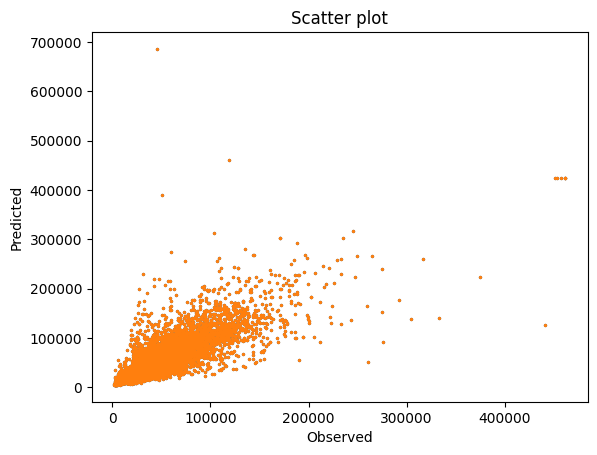

In [14]:
plot_model(Y_pred, Y_test)

Now I try to implement the SGD Regressor

In [15]:
from sklearn.linear_model import SGDRegressor
SGD_regression_model = SGDRegressor(alpha=0.0001, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='invscaling', loss='squared_error',
       n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
       shuffle=False, verbose=0, warm_start=False
)
training_data = train_df
Y_test, Y_pred = regression_test(SGD_regression_model, training_data)


Score: 0.721825923107364
MAE: 7980.963799633583


/Users/antonshtarkman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


These values are quite bad, I will not be coming back to this.

# Lasso Regression

Implementing Lasso Regression with different alpha levels to see if there is any alpha level that outperforms the rest. 

In [16]:
from sklearn.linear_model import Lasso
alpha = list(range(10))
alpha_list = [a/10 + 0.1 for a in alpha]

for a in alpha_list:
    print("Alpha: " + str(a))
    print("----------------")
    lasso_model = Lasso(alpha = a)
    training_data = train_df
    Y_test, Y_pred = regression_test(lasso_model, training_data)
    print("\n----------------")

Alpha: 0.1
----------------
Score: 0.7291861509007926
MAE: 7880.578264612154

----------------
Alpha: 0.2
----------------
Score: 0.7204771483254347
MAE: 7989.252681590216

----------------
Alpha: 0.30000000000000004
----------------
Score: 0.7308307715108455
MAE: 7886.3879567721415

----------------
Alpha: 0.4
----------------
Score: 0.7104079304707969
MAE: 7918.445732210238

----------------
Alpha: 0.5
----------------
Score: 0.7292651618166555
MAE: 7859.180007244458

----------------
Alpha: 0.6
----------------
Score: 0.7121040408674683
MAE: 7851.265584797683

----------------
Alpha: 0.7
----------------
Score: 0.7317284120423782
MAE: 7905.608404151615

----------------
Alpha: 0.7999999999999999
----------------
Score: 0.7168607581740514
MAE: 7952.159218623513

----------------
Alpha: 0.9
----------------
Score: 0.7171191043006695
MAE: 7871.944644880388

----------------
Alpha: 1.0
----------------
Score: 0.7246445781151984
MAE: 7900.858118453561

----------------


There is no real difference between changing each alpha 

# Ridge Regression

Similarly, implementing ridge regression with different alpha levels to see if there is any alpha level that outperforms the rest.

In [17]:
from sklearn.linear_model import Ridge
alpha = list(range(10))
alpha_list = [a/10 + 0.1 for a in alpha]

for a in alpha_list:
    print("Alpha: " + str(a))
    print("----------------")
    ridge_regression_model = Ridge(alpha = a)
    training_data = train_df
    Y_test, Y_pred = regression_test(ridge_regression_model, training_data)
    print("\n----------------")

Alpha: 0.1
----------------
Score: 0.7227209294977331
MAE: 7877.309173106933

----------------
Alpha: 0.2
----------------
Score: 0.7337631703705991
MAE: 7936.517576245606

----------------
Alpha: 0.30000000000000004
----------------
Score: 0.7079017863573196
MAE: 7933.479236286506

----------------
Alpha: 0.4
----------------
Score: 0.7210531086502316
MAE: 7886.757598913768

----------------
Alpha: 0.5
----------------
Score: 0.7123059908882384
MAE: 7882.9840423213245

----------------
Alpha: 0.6
----------------
Score: 0.6998938912087476
MAE: 7940.456190986311

----------------
Alpha: 0.7
----------------
Score: 0.7391719624798192
MAE: 7972.801912007526

----------------
Alpha: 0.7999999999999999
----------------
Score: 0.7222774321409482
MAE: 7938.647785243712

----------------
Alpha: 0.9
----------------
Score: 0.725898709482715
MAE: 7790.23427626034

----------------
Alpha: 1.0
----------------
Score: 0.7365210958733814
MAE: 7856.386092954597

----------------


Once again, no real difference between changing alpha

# Random Forest Regression

Implementing a random forest model

In [18]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(max_depth = 8, n_estimators = 100)
training_data = train_df
Y_test, Y_pred = regression_test(random_forest_model, training_data)

Score: 0.7556007278102105
MAE: 7694.510667884192


# Decision Tree Regression

Implementing a decision tree model

In [19]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(max_depth = 8)
training_data = train_df
Y_test, Y_pred = regression_test(tree_model, training_data)

Score: 0.726351444749762
MAE: 7998.632205302923


By comparing the score and MAE of these two, the random forest model seems to consistently outperform the decision tree model

# Elastic Net

Implementing ElasticNet - a regression model that overcomes the limitations of both Lasso and Ridge 

Score: 0.7135156790865795
MAE: 8021.517971973152


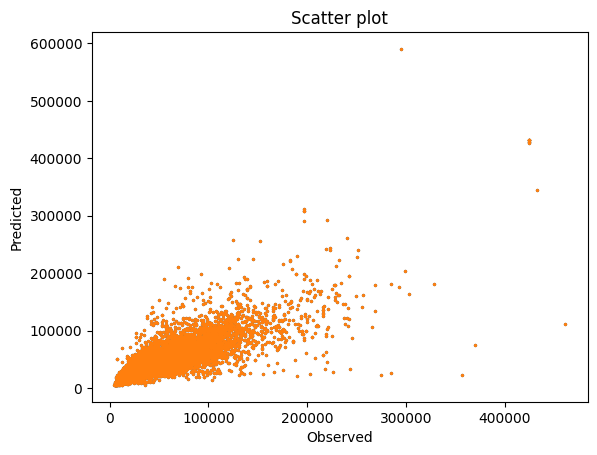

In [20]:
from sklearn.linear_model import ElasticNet
elastic_net_model = ElasticNet(alpha = 0.5)
training_data = train_df
Y_test, Y_pred = regression_test(elastic_net_model, training_data)
plot_model(Y_test, Y_pred)

Elastic net however does not perform better than Random Forest Regression. 

# MLP Regressor

Here I implement a MLP Regressor and try to do some hyper parameter tuning

Score: 0.8193407926654328
MAE: 6413.429208730915


/Users/antonshtarkman/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


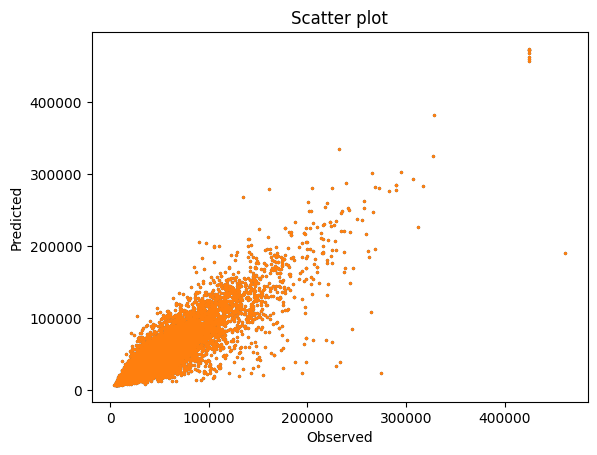

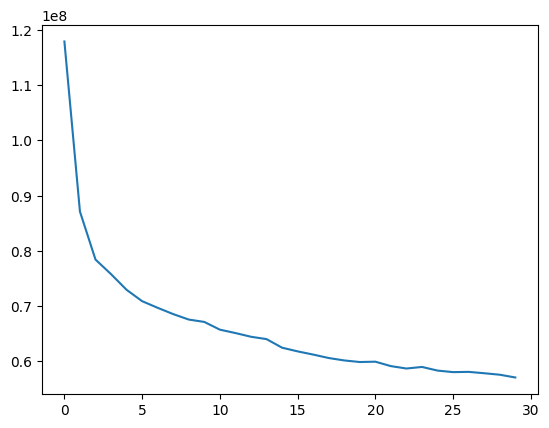

In [21]:
from sklearn.neural_network import MLPRegressor

layer_size =[30,10]  # 0.7939074212269913
layer_size = [5, 5]  # 0.7222901934357828
layer_size = [50, 50] # 0.8172343353932848
layer_size = [50] # 0.0.7706199263250595
layer_size = [5, 5, 5] # 0.760151118552116
layer_size = [10, 10, 10] # 0.8022043576801993
layer_size = [20, 10, 10] # 0.8167675247382208  #0.8063099523718297
layer_size = [50, 50] # 0.8172343353932848 # 0.8329269861372597
layer_size = [30, 20] # 0.8238186607847082 0.8237141499232239 0.8184203561639233
params = { 'hidden_layer_sizes' : layer_size,
'activation' : 'relu', 'solver' : 'adam',
'alpha' : 0.0, 'batch_size' : 64,
'random_state' : 0, 'tol' : 0.0001,
'nesterovs_momentum' : False,
'learning_rate' : 'adaptive',
'learning_rate_init' : 0.05,
'max_iter' : 30, 'shuffle' : True,
'n_iter_no_change' : 5, 'verbose' : False }

mlp_regression_model = MLPRegressor(**params)
training_data = train_df
Y_test, Y_pred = regression_test(mlp_regression_model, training_data)
plot_model(Y_test, Y_pred)
plt.plot(mlp_regression_model.loss_curve_)
plt.show()

The MLP Regressor seems to achieve the highest score and the lowest MAE

# Using the Grid Search to hypertune the parameters

This hypertuning was helped https://michael-fuchs-python.netlify.app/2021/02/10/nn-multi-layer-perceptron-regressor-mlpregressor/

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# Some grid tests
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [5, 5, 5],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

param_grid = {
    'hidden_layer_sizes': [(5, 5), (10, 10), (10, 5)],
}

X = train_df.copy()
Y = train_df['length']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train_features = train_df.columns[1:41]
X_test_features = test_df.columns[1:41]

X_test = X_test[X_test_features]
X_train = X_train[X_train_features]

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train_features = scaler.fit_transform(X_train)
scaled_X_test_features = scaler.transform(X_test)


mlp_reg = MLPRegressor(max_iter=50)
grid = GridSearchCV(mlp_reg, param_grid, n_jobs=-1, cv = 5)
grid.fit(scaled_X_train_features, Y_train)

print(grid.best_estimator_)
best_params = grid.best_estimator_.get_params()
print(best_params)

# Figuring out Word_Present

**Starting with Logistic Regression and differing split level to see if there is any improvement**

In [40]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression()
training_data = train_df
Y_test, Y_pred = classification_test(logistic_regression_model, training_data, 0.2, 0.5)

True Positive Rate : 0.456322424551127
False Positive Rate : 0.08413600065859883
Precision: 0.7780914124416458
Accuracy: 0.74


In [41]:
Y_test, Y_pred = classification_test(logistic_regression_model, training_data, 0.25, 0.5)

True Positive Rate : 0.4513157225021632
False Positive Rate : 0.08246301848252233
Precision: 0.7798592788038698
Accuracy: 0.73


In [42]:
Y_test, Y_pred = classification_test(logistic_regression_model, training_data, 0.3, 0.5)

True Positive Rate : 0.4487474437627812
False Positive Rate : 0.08207402540516864
Precision: 0.7784347054910945
Accuracy: 0.73


In [43]:
Y_test, Y_pred = classification_test(logistic_regression_model, training_data, 0.1, 0.5)

True Positive Rate : 0.45632549268912903
False Positive Rate : 0.08084054388133498
Precision: 0.7853391684901532
Accuracy: 0.74


In [44]:
Y_test, Y_pred = classification_test(logistic_regression_model, training_data, 0.15, 0.5)

True Positive Rate : 0.4551314673452078
False Positive Rate : 0.08358045030203184
Precision: 0.7790360046457607
Accuracy: 0.74


-----

**Now using Random Forest Classifer** 

**Choosing different max_depth in random forest**

In [52]:
from sklearn.ensemble import RandomForestClassifier
random_forest_word_model = RandomForestClassifier(n_estimators = 100, max_depth = 30)
training_data = train_df
Y_test, Y_pred = classification_test(random_forest_word_model, training_data, 0.2, 0.5)

True Positive Rate : 0.6090364516951313
False Positive Rate : 0.1160523284515386
Precision: 0.7720956535789304
Accuracy: 0.78


In [53]:
from sklearn.ensemble import RandomForestClassifier
random_forest_word_model = RandomForestClassifier(n_estimators = 100, max_depth = 20)
training_data = train_df
Y_test, Y_pred = classification_test(random_forest_word_model, training_data, 0.2, 0.5)


True Positive Rate : 0.5824036511156186
False Positive Rate : 0.10279062087186261
Precision: 0.7867785579722555
Accuracy: 0.77


Choosing the above model since it has the lowest FPR and a high precision and accuracy.

In [92]:
from sklearn.ensemble import RandomForestClassifier
random_forest_word_model = RandomForestClassifier(n_estimators = 100, max_depth = 80)
training_data = train_df
Y_test, Y_pred = classification_test(random_forest_word_model, training_data, 0.2, 0.5)


True Positive Rate : 0.6402092771007465
False Positive Rate : 0.1338430550417232
Precision: 0.7550037622272385
Accuracy: 0.78


In [56]:
from sklearn.ensemble import RandomForestClassifier
random_forest_word_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)
training_data = train_df
Y_test, Y_pred = classification_test(random_forest_word_model, training_data, 0.2, 0.5)

True Positive Rate : 0.5576639528174883
False Positive Rate : 0.10852014261710585
Precision: 0.7666343526923416
Accuracy: 0.76


In [62]:
from sklearn.neural_network import MLPClassifier

params = { 'hidden_layer_sizes' : [30,15],
'activation' : 'relu', 'solver' : 'adam',
'alpha' : 0.0, 'batch_size' : 64,
'random_state' : 0, 'tol' : 0.0001,
'nesterovs_momentum' : False,
'learning_rate' : 'constant',
'learning_rate_init' : 0.01,
'max_iter' : 500, 'shuffle' : True,
'n_iter_no_change' : 5, 'verbose' : False }

model = MLPClassifier(**params)

training_data = train_df
Y_test, Y_pred = classification_test(model, training_data, 0.2, 0.6)

True Positive Rate : 0.5338977656120695
False Positive Rate : 0.11588654234078466
Precision: 0.7487055882878058
Accuracy: 0.75


The random forest has the lowest FPR and as stated in the instructions, we want that to be as close to 0.05 as possible. However, the TPR is not the best from these models, but I prioritized lessening the FPR more than increasing the TPR.

# Figuring out edited_2023

First creating a dataframe including the 0/1-valued variable refered to as edited_2023

In [63]:
edited_2023_df = train_df.copy()
# Create a dataframe with an edited_2023 variable
edited_2023_df["edited_2023"] = (pd.to_datetime(train_df["date"]).dt.year == 2023).astype(int)

**Running Logistic Regression on the response variable with different params**

In [68]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression()
training_data = edited_2023_df
Y_test, Y_pred = classification_test(logistic_regression_model, training_data, 0.2, 0.5)

True Positive Rate : 0.45307319561336395
False Positive Rate : 0.08257937160717223
Precision: 0.7796796137809963
Accuracy: 0.74


In [69]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(penalty = 'l2', solver = 'newton-cg')
training_data = edited_2023_df
Y_test, Y_pred = classification_test(logistic_regression_model, training_data, 0.2, 0.5)

True Positive Rate : 0.44929207508488694
False Positive Rate : 0.08585133860850314
Precision: 0.7700669814428461
Accuracy: 0.73


I will use this model for edited_2023 because of the aggresive penalty - the FPR is lower. Additionally, the precision and accuracy are not bad here.

In [70]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(penalty = 'l1', solver = 'liblinear')
training_data = edited_2023_df
Y_test, Y_pred = classification_test(logistic_regression_model, training_data, 0.2, 0.5)

True Positive Rate : 0.44903372489579385
False Positive Rate : 0.08185053380782918
Precision: 0.782350352112676
Accuracy: 0.73


Using this logistic model since it has the lowest FPR although not the highest TPR.

**Running Random Forest Classifier on the response variable max_depth 20**

In [67]:
from sklearn.ensemble import RandomForestClassifier
random_forest_word_model = RandomForestClassifier(n_estimators = 100, max_depth = 20)
training_data = edited_2023_df
Y_test, Y_pred = classification_test(random_forest_word_model, training_data, 0.2, 0.5)

True Positive Rate : 0.580453907943389
False Positive Rate : 0.10339721970880975
Precision: 0.7836302607797573
Accuracy: 0.77


In [72]:
from sklearn.neural_network import MLPClassifier

params = { 'hidden_layer_sizes' : [10, 5, 3],
'activation' : 'relu', 'solver' : 'adam',
'alpha' : 0.0, 'batch_size' : 64,
'random_state' : 0, 'tol' : 0.0001,
'nesterovs_momentum' : False,
'learning_rate' : 'constant',
'learning_rate_init' : 0.01,
'max_iter' : 500, 'shuffle' : True,
'n_iter_no_change' : 5, 'verbose' : False }

mlp_classifier_model = MLPClassifier(**params)

training_data = edited_2023_df
Y_test, Y_pred = classification_test(mlp_classifier_model, training_data, 0.2, 0.5, field="edited_2023")

True Positive Rate : 0.8558995686999384
False Positive Rate : 0.5922890535917902
Precision: 0.7278383600222681
Accuracy: 0.70


MLP has a pretty large FPR even though its TPR is significantly better - will not be using this.

# Picking models and creating the CSV file

# First predicting length

For length, the highest score and lowest MAE was acquired via the MLP regressor with the layer_size = [30,20]

In [76]:
from sklearn.neural_network import MLPRegressor

params = { 'hidden_layer_sizes' : [30,20],
'activation' : 'relu', 'solver' : 'adam',
'alpha' : 0.0, 'batch_size' : 64,
'random_state' : 0, 'tol' : 0.0001,
'nesterovs_momentum' : False,
'learning_rate' : 'adaptive',
'learning_rate_init' : 0.05,
'max_iter' : 500, 'shuffle' : True,
'n_iter_no_change' : 5, 'verbose' : False }

mlp_regressor_length_model = MLPRegressor(**params)

scaler = StandardScaler()

testing_data = test_df.copy()
X_test_features = testing_data.columns[1:41]
final_testing_data = test_df[X_test_features]
final_testing_data_array = final_testing_data.values

training_data = train_df.copy()
X_train_features = training_data.columns[1:41]
final_training_data = train_df[X_train_features]
final_training_data_array = final_training_data.values
Y = training_data['length']

scaler.fit(final_training_data_array)

scaled_X_train_features = scaler.transform(final_training_data_array)
scaled_X_test_features = scaler.transform(final_testing_data_array)
    
model = mlp_regressor_length_model.fit(scaled_X_train_features, Y.values)
length_pred = model.predict(scaled_X_test_features) 


In [77]:
print(length_pred)

[44942.99417778 16362.94185523 15969.92244613 ... 11120.85078335
 18708.64040326 10923.42671604]


(array([4.355e+04, 5.153e+03, 1.007e+03, 1.890e+02, 5.200e+01, 2.700e+01,
        6.000e+00, 4.000e+00, 1.100e+01, 1.000e+00]),
 array([   480.88429862,  47818.61845526,  95156.35261191, 142494.08676855,
        189831.82092519, 237169.55508184, 284507.28923848, 331845.02339512,
        379182.75755177, 426520.49170841, 473858.22586505]),
 <BarContainer object of 10 artists>)

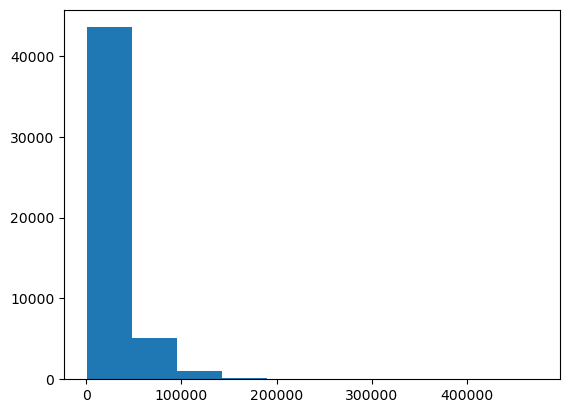

In [78]:
plt.hist(length_pred)

(array([1.87767e+05, 1.03310e+04, 1.48400e+03, 3.11000e+02, 6.30000e+01,
        4.00000e+00, 3.90000e+01, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  4411. ,  72558.4, 140705.8, 208853.2, 277000.6, 345148. ,
        413295.4, 481442.8, 549590.2, 617737.6, 685885. ]),
 <BarContainer object of 10 artists>)

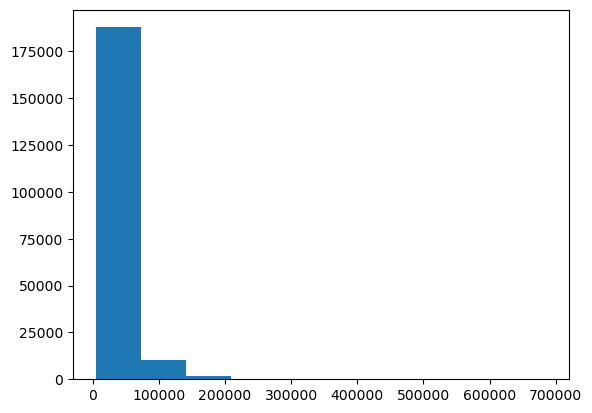

In [79]:
plt.hist(Y)

# Now moving onto predicting word_present

For word_present, random forest with n_estimators of 100 and max_depth of 30 worked the best.

In [80]:
from sklearn.ensemble import RandomForestClassifier

random_forest_word_model = RandomForestClassifier(n_estimators = 100, max_depth = 20)

scaler = StandardScaler()

testing_data = test_df.copy()
X_test_features = testing_data.columns[1:41]
final_testing_data = test_df[X_test_features]
final_testing_data_array = final_testing_data.values

print(final_testing_data_array.shape) 

training_data = train_df.copy()
X_train_features = training_data.columns[1:41]
final_training_data = train_df[X_train_features]
final_training_data_array = final_training_data.values
Y = training_data['word_present']

scaler.fit(final_training_data_array)

scaled_X_train_features = scaler.transform(final_training_data_array)
scaled_X_test_features = scaler.transform(final_testing_data_array)
    
model = random_forest_word_model.fit(scaled_X_train_features, Y.values)
word_pred = model.predict(scaled_X_test_features) 


(50000, 40)


In [81]:
print(word_pred)

[1 0 0 ... 0 0 0]


(array([35588.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14412.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

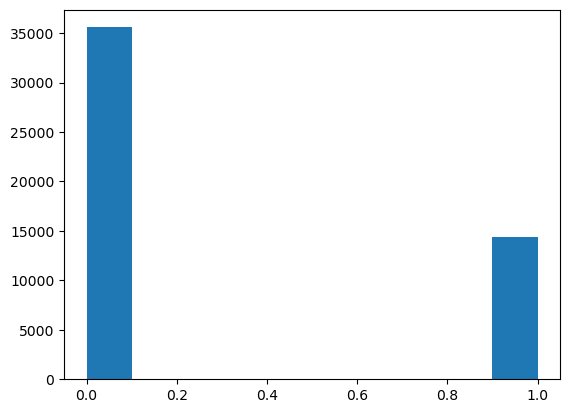

In [82]:
plt.hist(word_pred)

(array([121510.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  78490.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

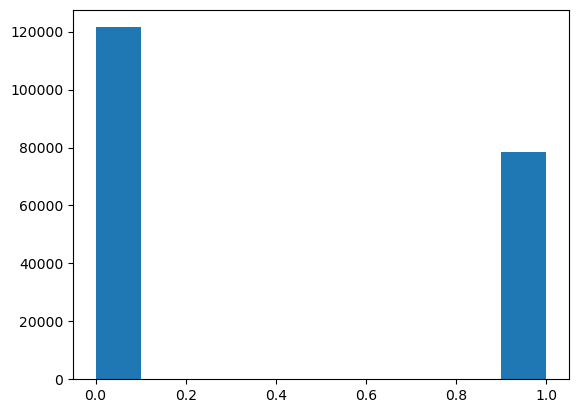

In [83]:
plt.hist(Y)

In [84]:
from sklearn.linear_model import LogisticRegression

logistic_regression_date_model = LogisticRegression(penalty = 'l2', solver = 'newton-cg')

scaler = StandardScaler()

testing_data = test_df.copy()
X_test_features = testing_data.columns[1:41]
final_testing_data = test_df[X_test_features]
final_testing_data_array = final_testing_data.values

print(final_testing_data_array.shape)

training_data = edited_2023_df.copy()
X_train_features = training_data.columns[1:41]
final_training_data = train_df[X_train_features]
final_training_data_array = final_training_data.values
Y = training_data['edited_2023']

scaler.fit(final_training_data_array)

scaled_X_train_features = scaler.transform(final_training_data_array)
scaled_X_test_features = scaler.transform(final_testing_data_array)
    
model = random_forest_word_model.fit(scaled_X_train_features, Y.values)
date_pred = model.predict(scaled_X_test_features) 



(50000, 40)


In [85]:
print(date_pred)

[1 0 0 ... 0 0 1]


(array([13168.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 36832.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

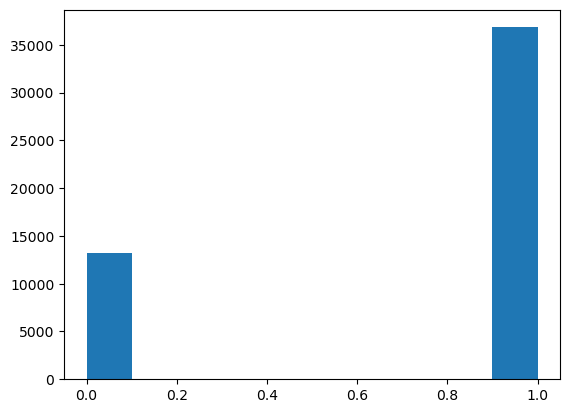

In [87]:
plt.hist(date_pred)

(array([ 69422.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 130578.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

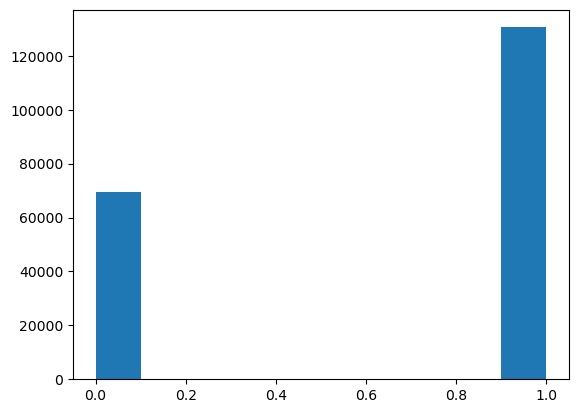

In [88]:
plt.hist(Y)

In [91]:
import pandas as pd

final_data_set = pd.DataFrame()


final_data_set['URLID'] = test_df['URLID']

final_data_set['length'] = length_pred

final_data_set['word_present'] = word_pred

final_data_set['edited_2023'] = date_pred

file_path = '/Users/antonshtarkman/Desktop/Shtarkman_Prediction_Data_Set.csv'

final_data_set.to_csv(file_path, index = False)
